In [2]:
import sys
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency
from sklearn.preprocessing import normalize 
from time import gmtime
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.cluster import KMeans
from scipy.stats import wilcoxon

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.insert(0, '')

In [4]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=3)

In [5]:
path = "/Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/"
files = [
    "2017/25-12-2017_17-24.bdf",
    "2017/29-12-2017_16-18.bdf",
    "2018/02-01-2018_19-06.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/10-01-2018_15-09.bdf",
    "2018/13-01-2018_19-37.bdf",
    "2018/15-01-2018_18-07.bdf",
]

In [6]:
def skip_damaged_epoch(start_time):
    """
    """
    
    n_skip = 0
    
    # skip seconds
    
    if start_time[5] > 0:
        n_skip += (60-start_time[5])*fs
        
        start_time[5] = 0
        start_time[4] += 1
        
    # skip minutes
    
    dummy = str(start_time[4])
    
    if len(dummy) == 2:
        ones = int(dummy[1])
        tens = int(dummy[0])
    else:
        ones = int(dummy[0])
        tens = 0
    
    if ones > 0:
        n_skip += (10-ones)*fs*60
        
        if tens == 5:
            start_time[4] = 0
            start_time[3] += 1
        else:
            start_time[4] += (10-ones) #TODO 
    
    return n_skip

In [5]:
temp = pd.read_csv("/Users/wassilyminkow/Data/Rat_Data/RatTemperature.csv", sep=",")
temp["Power 1 - 4 Hz"] = np.nan 
temp["Power 4 - 8 Hz"] = np.nan 
temp["Power"] = np.nan 
temp["Acceleration"] = np.nan 
    
path = "/Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/"
files = [
    "2017/25-12-2017_17-24.bdf",
    "2017/29-12-2017_16-18.bdf",
    "2018/02-01-2018_19-06.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/10-01-2018_15-09.bdf",
    "2018/13-01-2018_19-37.bdf",
]
    
fs = 250
    
for file in files:
    
    # read EEG and acceleration data
    raw_data = mne.io.read_raw_edf(path+file)
    df = pd.DataFrame(raw_data.get_data([0, 2]), index=[raw_data.ch_names[0], raw_data.ch_names[2]]).T
    
    start = list(gmtime(raw_data.info['meas_date'][0]))
    
    n_skip = skip_damaged_epoch(start)
    
    df_new = df.iloc[n_skip:, ]
    
    n_epocs = int(np.floor(df_new.shape[0]/fs/60/10))
    n_samples = int(n_epocs*10*60*fs)
    
    df_epocs = df_new.iloc[:n_samples, :]
    
    start_epoc = temp[(temp['Year']==start[0])&(temp['Month']==start[1])&(temp['Day']==start[2])&(temp['Hour']==start[3])&(temp['Minute']==start[4])].index[0]
    
    temp_epocs = temp.iloc[start_epoc:start_epoc+n_epocs, -1]
    
    n_slises = 20
    step = fs*60*10

    order = 400 # filter order
    a = 1 

    band = np.array([1, 4])    
    b = firwin(order, band * 2 / fs, width=None, window='hamming', pass_zero=False)  # design filter
    df_epocs_low = filtfilt(b, a, df_epocs.iloc[:, 0]) # apply filter

    band = np.array([4, 8])    
    b = firwin(order, band * 2 / fs, width=None, window='hamming', pass_zero=False)  # design filter
    df_epocs_hi = filtfilt(b, a, df_epocs.iloc[:, 0])

    sum_power_low = np.array(list(map(lambda i: (df_epocs_low[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
    sum_power_hi = np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
    sum_power = np.array(list(map(lambda i: (df_epocs.iloc[i*step:(i+1)*step, 0]**2).mean(), np.arange(n_epocs))))
    sum_a = np.array(list(map(lambda i: (np.abs(df_epocs.iloc[i*step:(i+1)*step, 1]-df_epocs.iloc[i*step:(i+1)*step, 1].mean())).mean(), np.arange(n_epocs))))

    temp.iloc[start_epoc:start_epoc+n_epocs,-4] = sum_power_low*1e3
    temp.iloc[start_epoc:start_epoc+n_epocs,-3] = sum_power_hi*1e3
    temp.iloc[start_epoc:start_epoc+n_epocs,-2] = sum_power*1e3
    temp.iloc[start_epoc:start_epoc+n_epocs,-1] = sum_a*1e-1

    del df_epocs_low, df_epocs_hi, sum_power_low, sum_power_hi, sum_power, sum_a, raw_data, df, df_new

Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2017/25-12-2017_17-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-860a17a879ca>:23: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-5-860a17a879ca>:23: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2017/29-12-2017_16-18.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-860a17a879ca>:23: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-5-860a17a879ca>:23: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/02-01-2018_19-06.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-860a17a879ca>:23: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-5-860a17a879ca>:23: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/06-01-2018_18-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-860a17a879ca>:23: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-5-860a17a879ca>:23: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/06-01-2018_18-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-860a17a879ca>:23: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-5-860a17a879ca>:23: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/10-01-2018_15-09.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-860a17a879ca>:23: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-5-860a17a879ca>:23: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/13-01-2018_19-37.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-860a17a879ca>:23: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-5-860a17a879ca>:23: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


In [6]:
time_array = temp.dropna().index/6/24

In [21]:
temp['Temperature'] -= 273.15

In [22]:
temp

,Page,Record,Period,Year,Month,Day,Hour,Minute,Second,Ubat,Temperature,Power 1 - 4 Hz,Power 4 - 8 Hz,Power,Acceleration
0,132,25,10,2017,12,25,0,0,0,3.0,36.228,NaN,NaN,NaN,NaN
1,132,26,10,2017,12,25,0,10,0,3.0,36.549,NaN,NaN,NaN,NaN
2,132,27,10,2017,12,25,0,20,0,3.0,36.493,NaN,NaN,NaN,NaN
3,132,28,10,2017,12,25,0,30,0,3.0,36.455,NaN,NaN,NaN,NaN
4,133,1,10,2017,12,25,0,40,0,3.0,36.534,NaN,NaN,NaN,NaN
5,133,2,10,2017,12,25,0,50,0,3.0,36.553,NaN,NaN,NaN,NaN
6,133,3,10,2017,12,25,1,0,0,3.0,36.673,NaN,NaN,NaN,NaN
7,133,4,10,2017,12,25,1,10,0,3.0,36.434,NaN,NaN,NaN,NaN
8,133,5,10,2017,12,25,1,20,0,3.0,36.201,NaN,NaN,NaN,NaN
9,133,6,10,2017,12,25,1,30,0,3.0,36.339,NaN,NaN,NaN,NaN


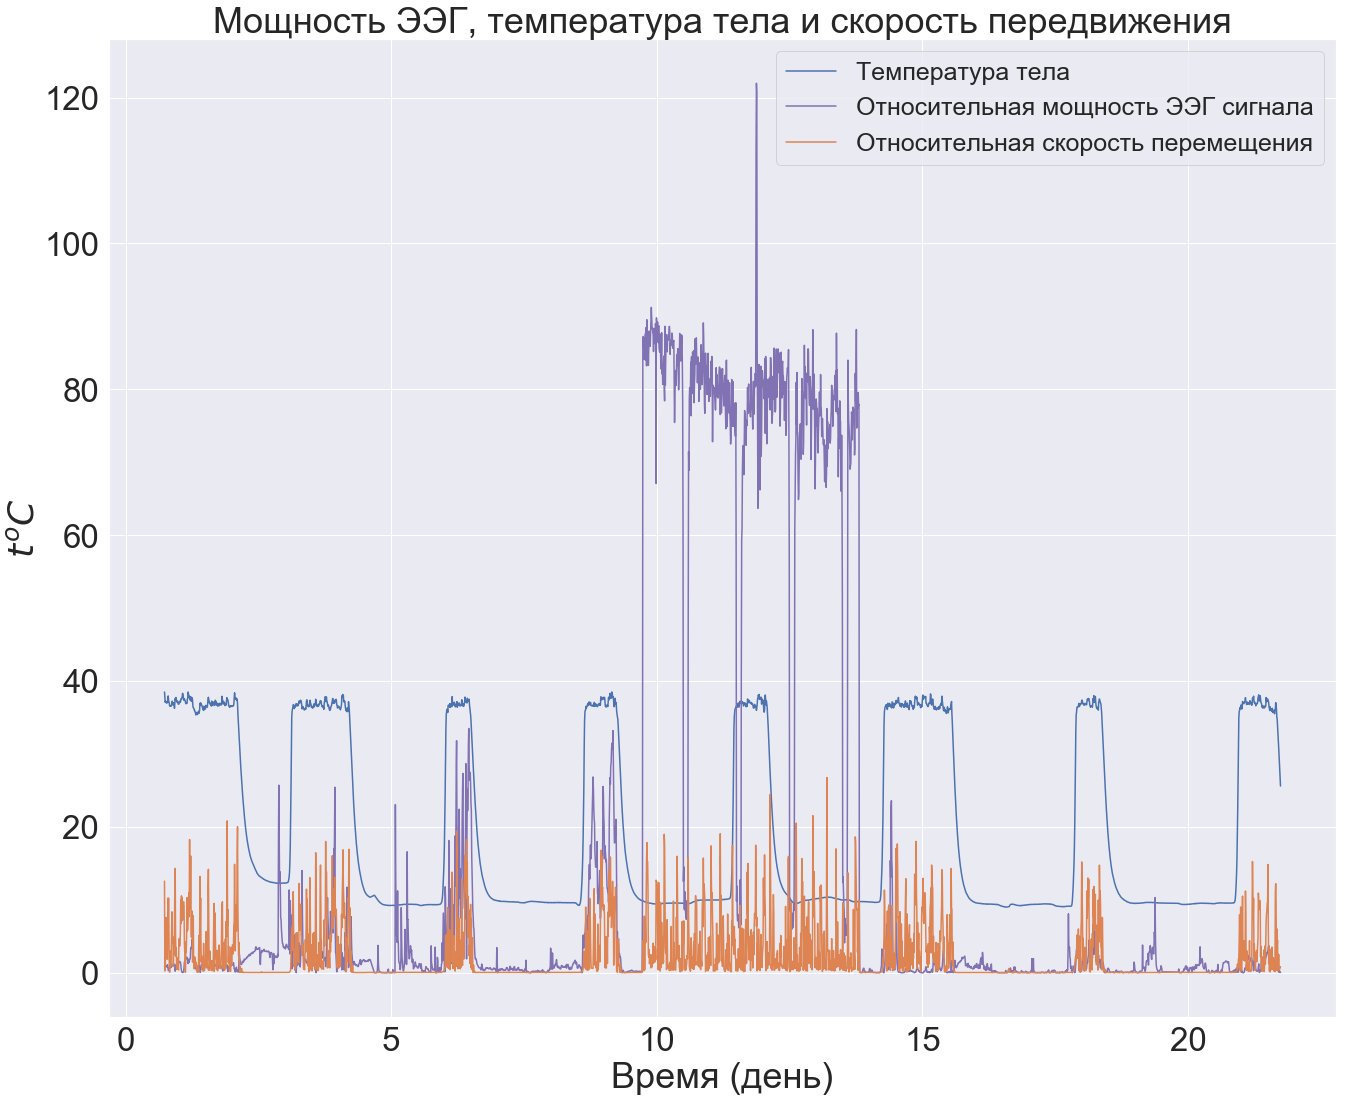

In [39]:
plt.plot(time_array, temp.dropna().iloc[:, -5], label="Температура тела")
plt.plot(time_array, temp.dropna().iloc[:, -2], label="Относительная мощность ЭЭГ сигнала", color="C4")
plt.plot(time_array, temp.dropna().iloc[:, -1], label="Относительная скорость перемещения")

# plt.ylim([0, 40])
plt.title("Мощность ЭЭГ, температура тела и скорость передвижения")
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend(prop={'size': 25})
plt.show()

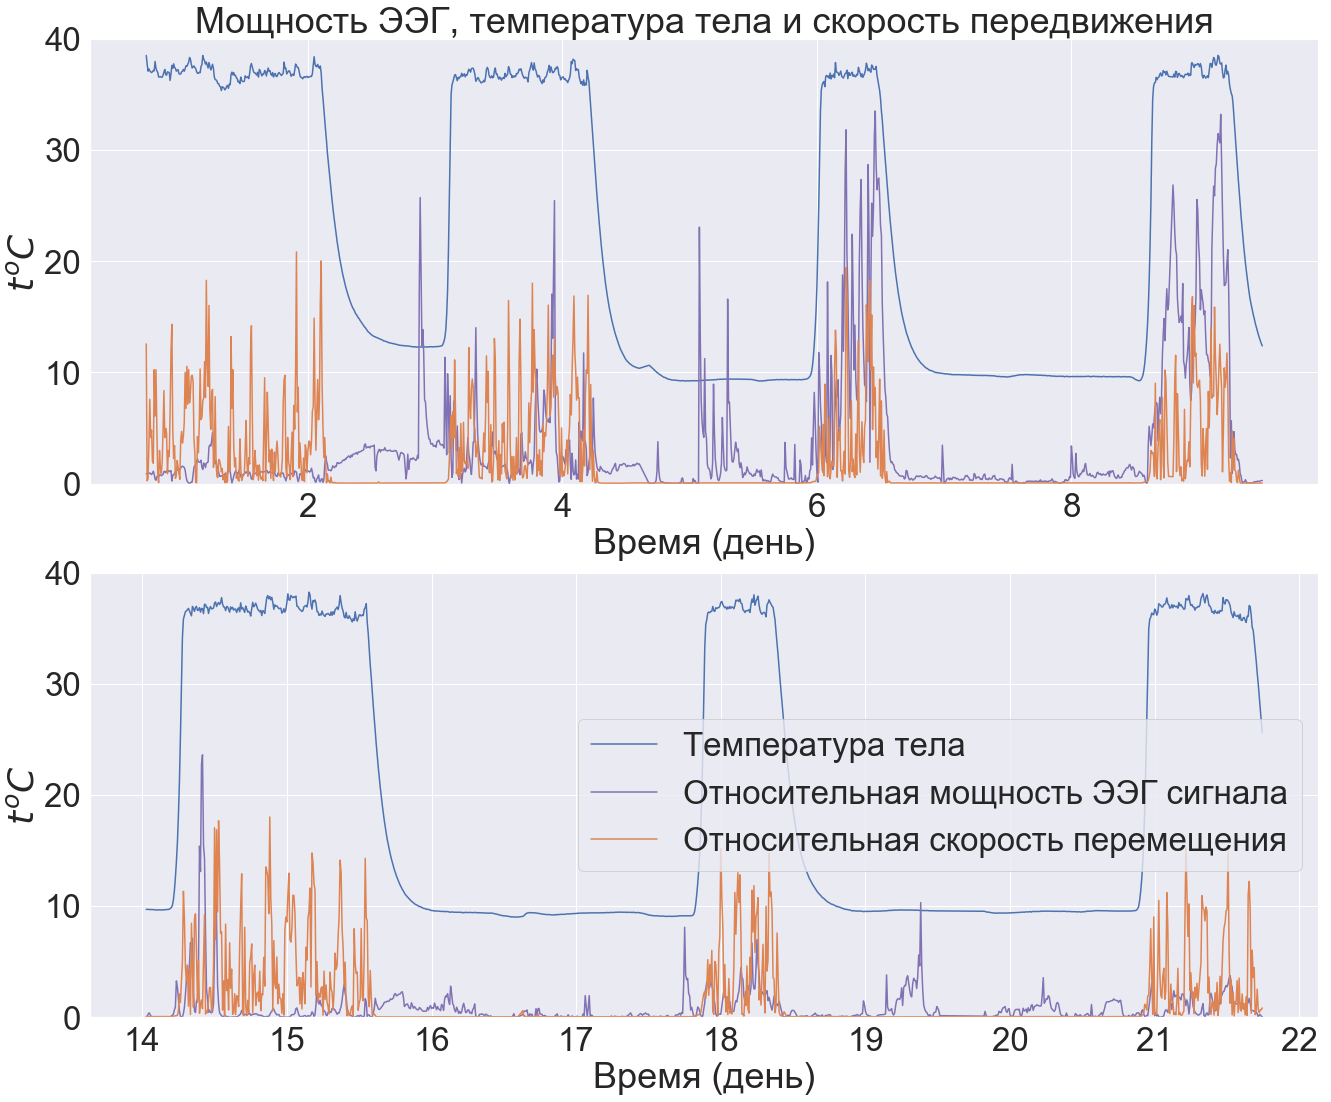

In [40]:
time_array = temp.dropna().index/6/24

skip_start = 1250
skip_end = 1900

plt.subplot(2, 1, 1)

plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -5], label="Температура тела") 
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -2], label="Относительная мощность ЭЭГ сигнала", color="C4")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -1], label="Относительная скорость перемещения")

plt.ylim([0, 40])
plt.title("Мощность ЭЭГ, температура тела и скорость передвижения")
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
# plt.legend()

plt.subplot(2, 1, 2)

plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -5], label="Температура тела") 
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -2], label="Относительная мощность ЭЭГ сигнала", color="C4")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -1], label="Относительная скорость перемещения")

plt.ylim([0, 40])
# plt.title("Физиологические показатели крысы")
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

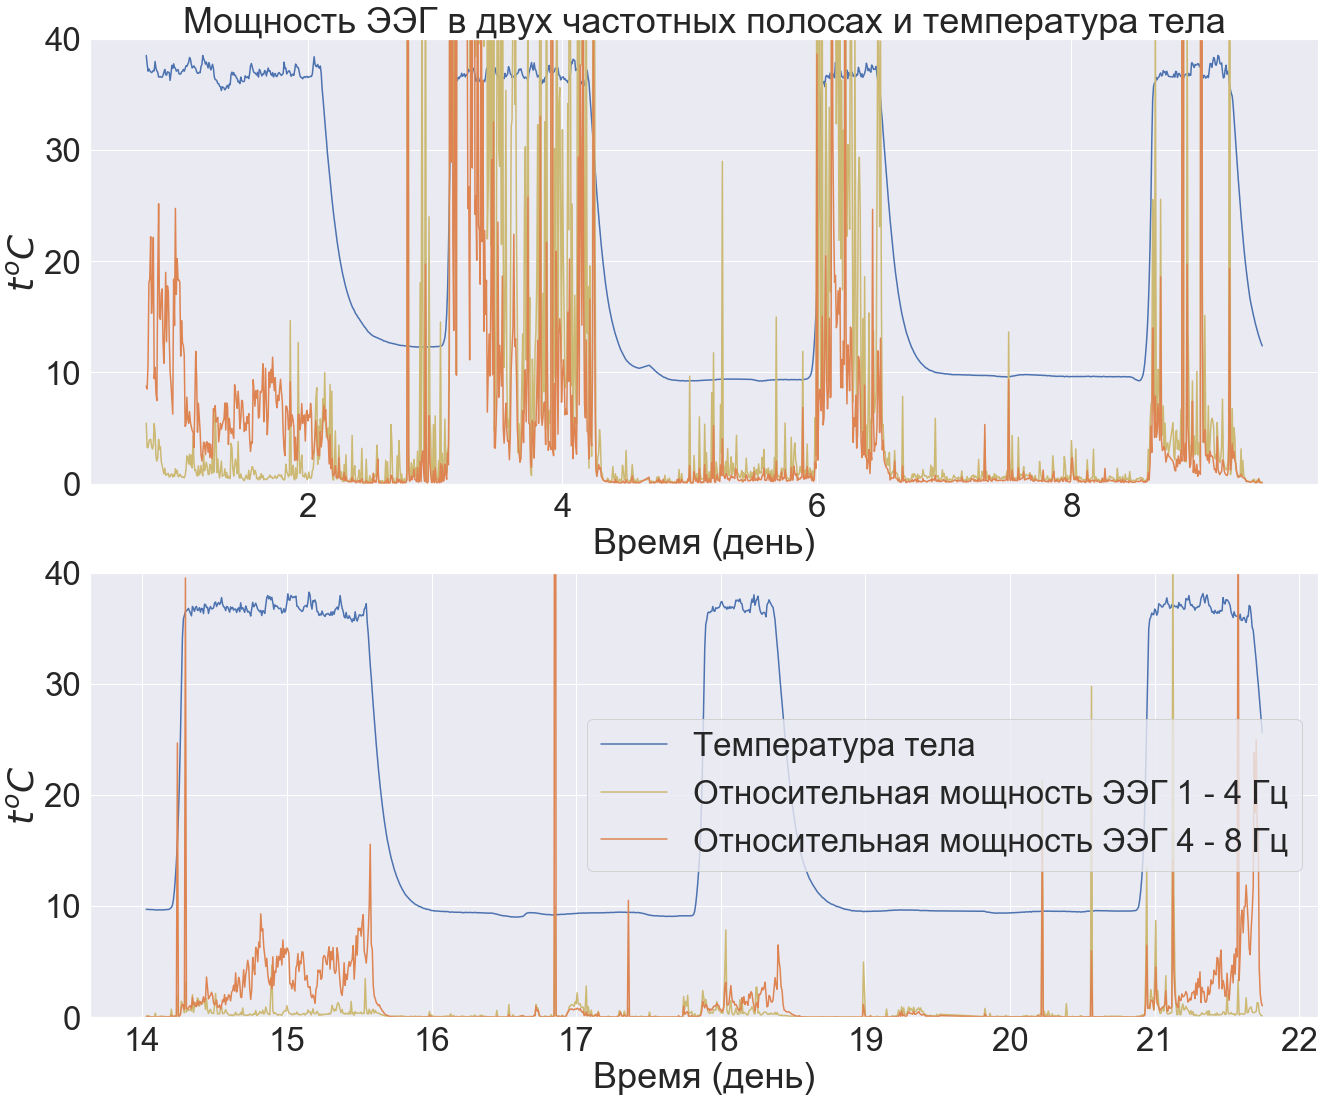

In [41]:
time_array = temp.dropna().index/6/24

skip_start = 1250
skip_end = 1900

coef = 1e7

plt.subplot(2, 1, 1)

plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -5], label="Температура тела") 
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -4]*coef, label="Мощность ЭЭГ сигнала 1 - 4 Гц", color="C8")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -3]*coef*10, label="Мощность ЭЭГ сигнала 4 - 8 Гц", color="C1")
# plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -1], label="Скорость перемещения")

plt.ylim([0, 40])
plt.title("Мощность ЭЭГ в двух частотных полосах и температура тела")
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
# plt.legend()

plt.subplot(2, 1, 2)

plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -5], label="Температура тела") 
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -4]*coef, label="Относительная мощность ЭЭГ 1 - 4 Гц", color="C8")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -3]*coef*10, label="Относительная мощность ЭЭГ 4 - 8 Гц", color="C1")
# plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -1], label="Скорость перемещения")

# plt.title("Физиологические показатели крысы")
plt.ylim([0, 40])
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

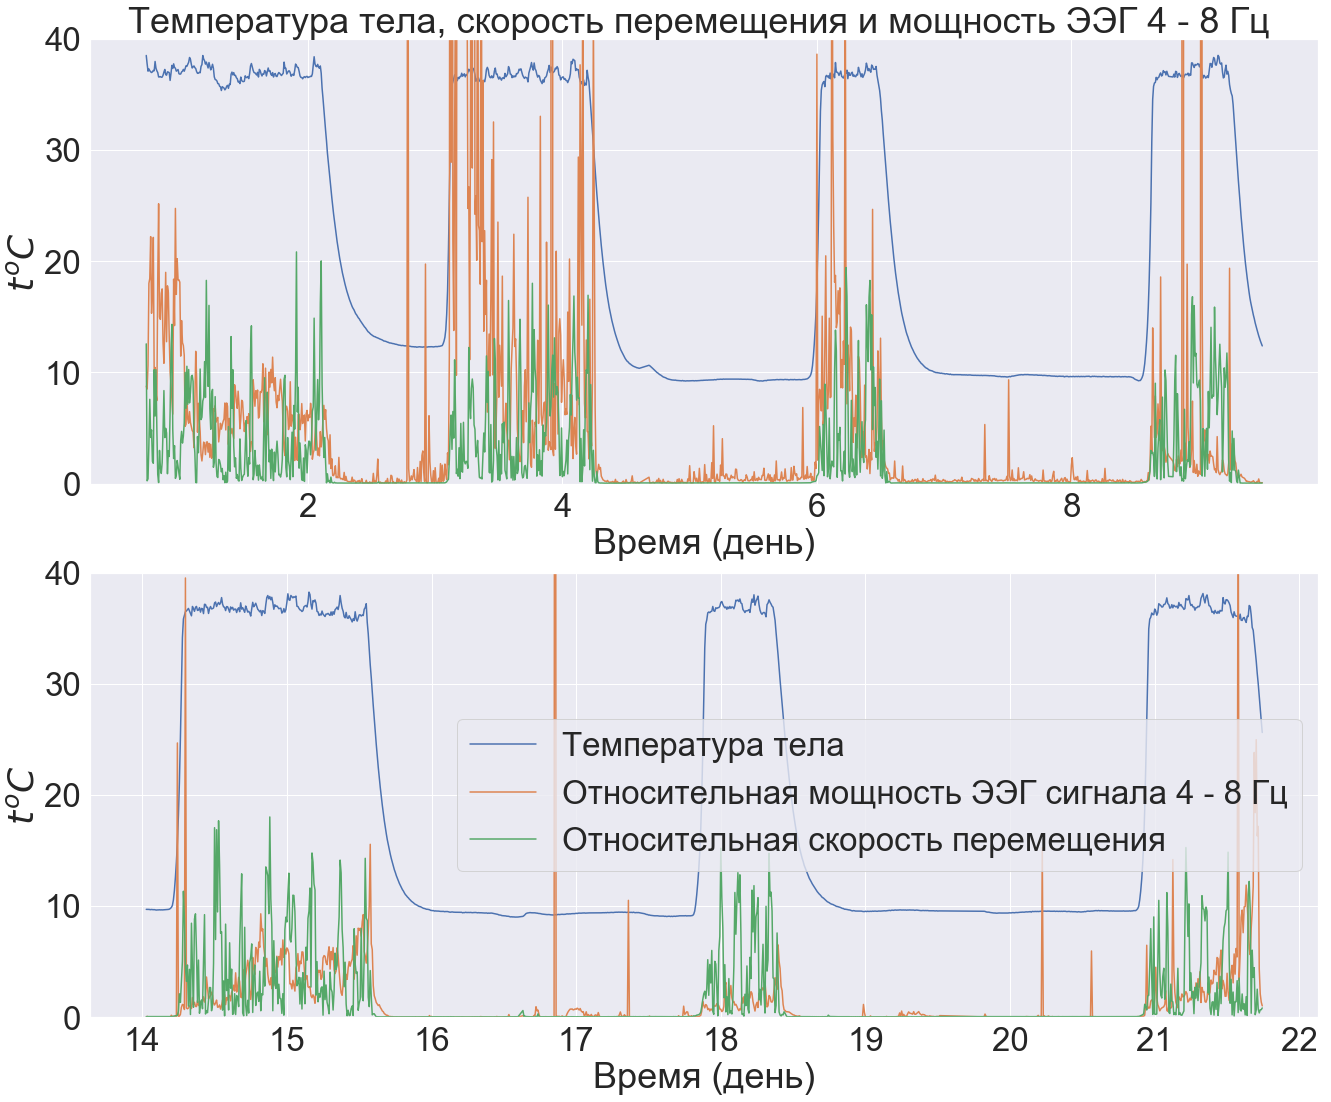

In [42]:
time_array = temp.dropna().index/6/24

skip_start = 1250
skip_end = 1900

plt.subplot(2, 1, 1)

plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -5], label="Температура тела") 
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -3]*coef*10, label="Мощность ЭЭГ сигнала 4 - 8 Гц")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -1], label="Скорость перемещения")

plt.title("Температура тела, скорость перемещения и мощность ЭЭГ 4 - 8 Гц ")
plt.ylim([0, 40])
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
# plt.legend()

plt.subplot(2, 1, 2)

plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -5], label="Температура тела") 
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -3]*coef*10, label="Относительная мощность ЭЭГ сигнала 4 - 8 Гц")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -1], label="Относительная cкорость перемещения")

# plt.title("Физиологические показатели крысы")
plt.ylim([0, 40])
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

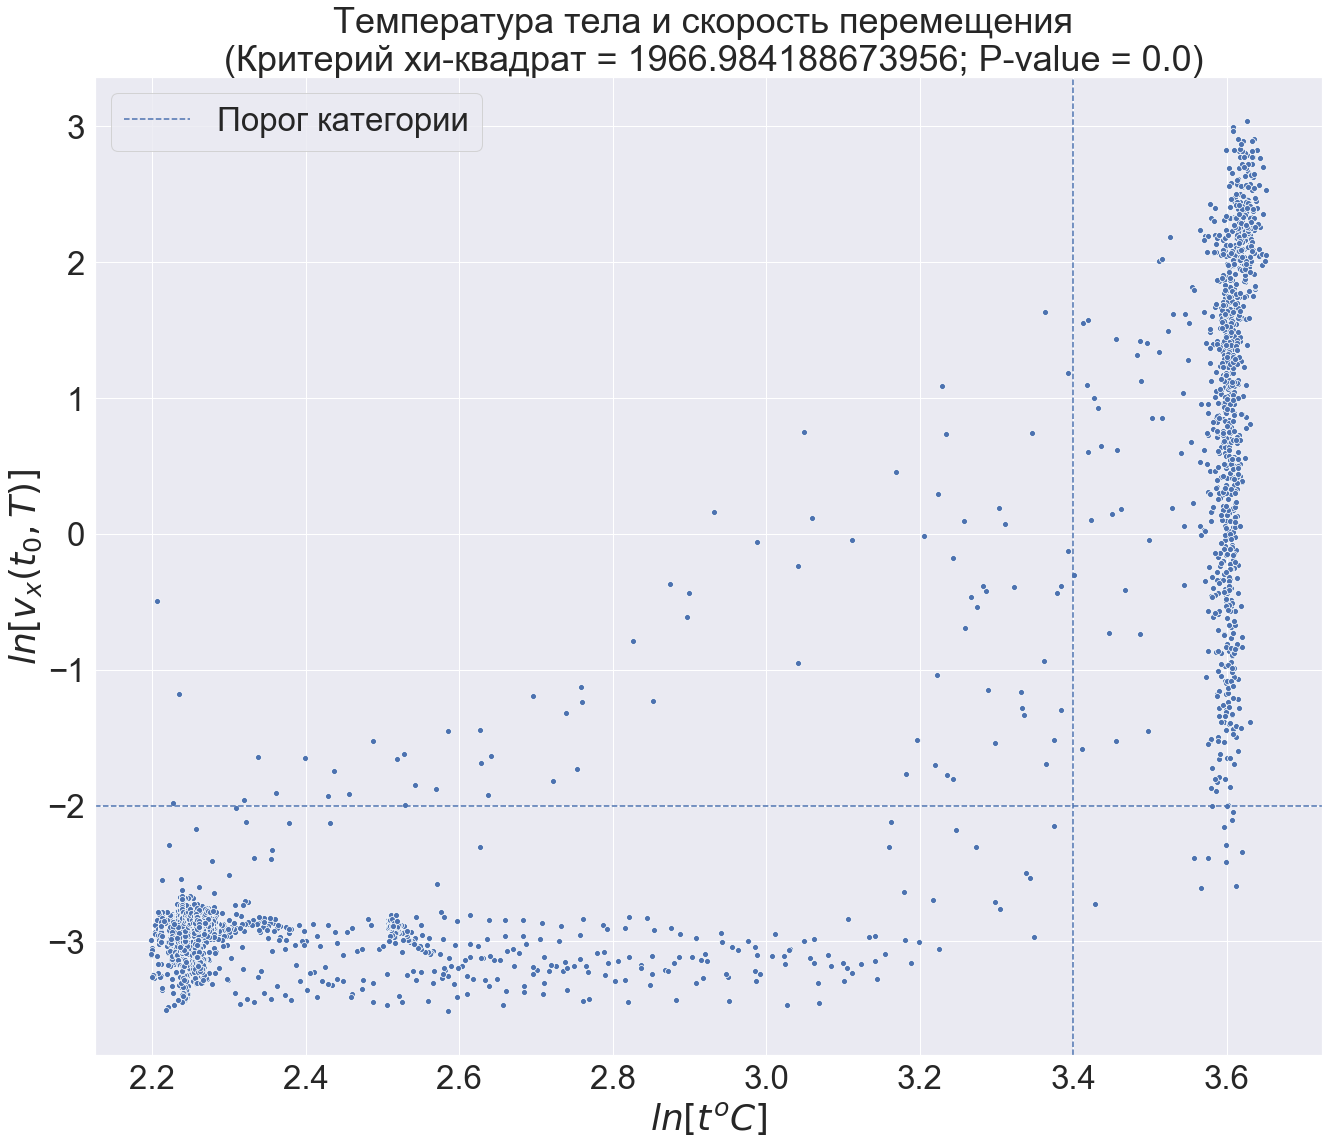

In [27]:
foo = lambda x: np.log(x)

x = foo(pd.concat([temp.dropna().iloc[:skip_start, -5], temp.dropna().iloc[skip_end:, -5]], axis=0))
y = foo(pd.concat([temp.dropna().iloc[:skip_start, -1], temp.dropna().iloc[skip_end:, -1]], axis=0))
o = np.ones(x.shape[0])

thx = 3.4
thy = -2

a = sum(o[(x < thx) & (y > thy)])
b = sum(o[(x > thx) & (y > thy)])
c = sum(o[(x < thx) & (y < thy)])
d = sum(o[(x > thx) & (y < thy)])

g, p, dof, expctd = chi2_contingency(np.array([[a, b], [c, d]]))

plt.axvline(x=thx, linestyle = "--",  label="Порог категории")
plt.axhline(y=thy, linestyle = "--")
sns.scatterplot(x=x, y=y)
plt.title("Температура тела и скорость перемещения \n (Критерий хи-квадрат = {}; P-value = {})".format(g, p))
plt.ylabel(r"$ln[v_{x}(t_0, T)]$")
plt.xlabel(r"$ln[t^o C]$")
plt
plt.show()

In [28]:
# TODO make an algorithm, that will count it for me

dec_begs = np.array([280, 600, 930, 2230, 2640, 3110])
dec_ends = np.array([400, 700, 1000, 2300, 2750, 3200])

inc_begs = np.array([440, 850, 1230, 2560, 3000])
inc_ends = np.array([460, 880, skip_start, 2590, 3030])

inc = pd.concat([temp.iloc[inc_begs[i]:inc_ends[i], :] for i in range(inc_begs.shape[0])], axis=0).dropna()
dec = pd.concat([temp.iloc[dec_begs[i]:dec_ends[i], :] for i in range(dec_begs.shape[0])], axis=0).dropna()

In [29]:
main = pd.concat([temp.dropna().iloc[:skip_start, :], temp.dropna().iloc[skip_end:, :]], axis=0)
main_wake = main[main["Temperature"] > 35]
main_sleep = main[main["Temperature"] < 15]

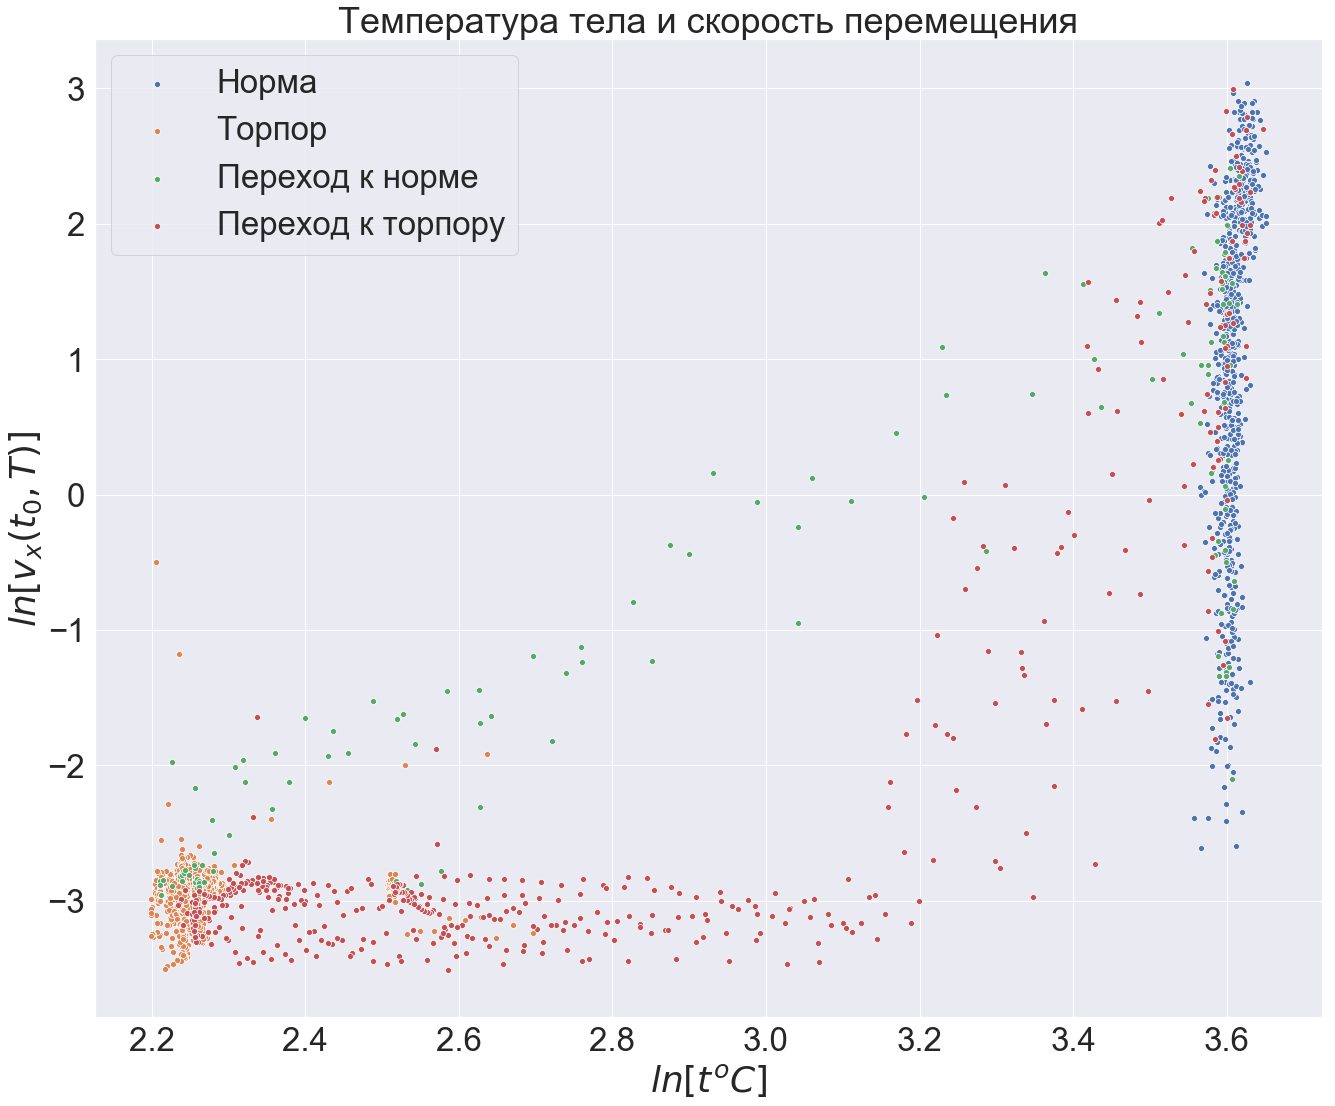

In [30]:
foo = lambda x : np.log(x)

sns.scatterplot(x=foo(main_wake.iloc[:, -5]), y=foo(main_wake.iloc[:, -1]), label="Норма", sizes=100)
sns.scatterplot(x=foo(main_sleep.iloc[:, -5]), y=foo(main_sleep.iloc[:, -1]), label="Торпор")
sns.scatterplot(x=foo(inc.iloc[:, -5]), y=foo(inc.iloc[:, -1]), label="Переход к норме")
sns.scatterplot(x=foo(dec.iloc[:, -5]), y=foo(dec.iloc[:, -1]), label="Переход к торпору")
plt.ylabel(r"$ln[v_{x}(t_0, T)]$")
plt.xlabel(r"$ln[t^o C]$")
plt.title("Температура тела и скорость перемещения")
plt.show()

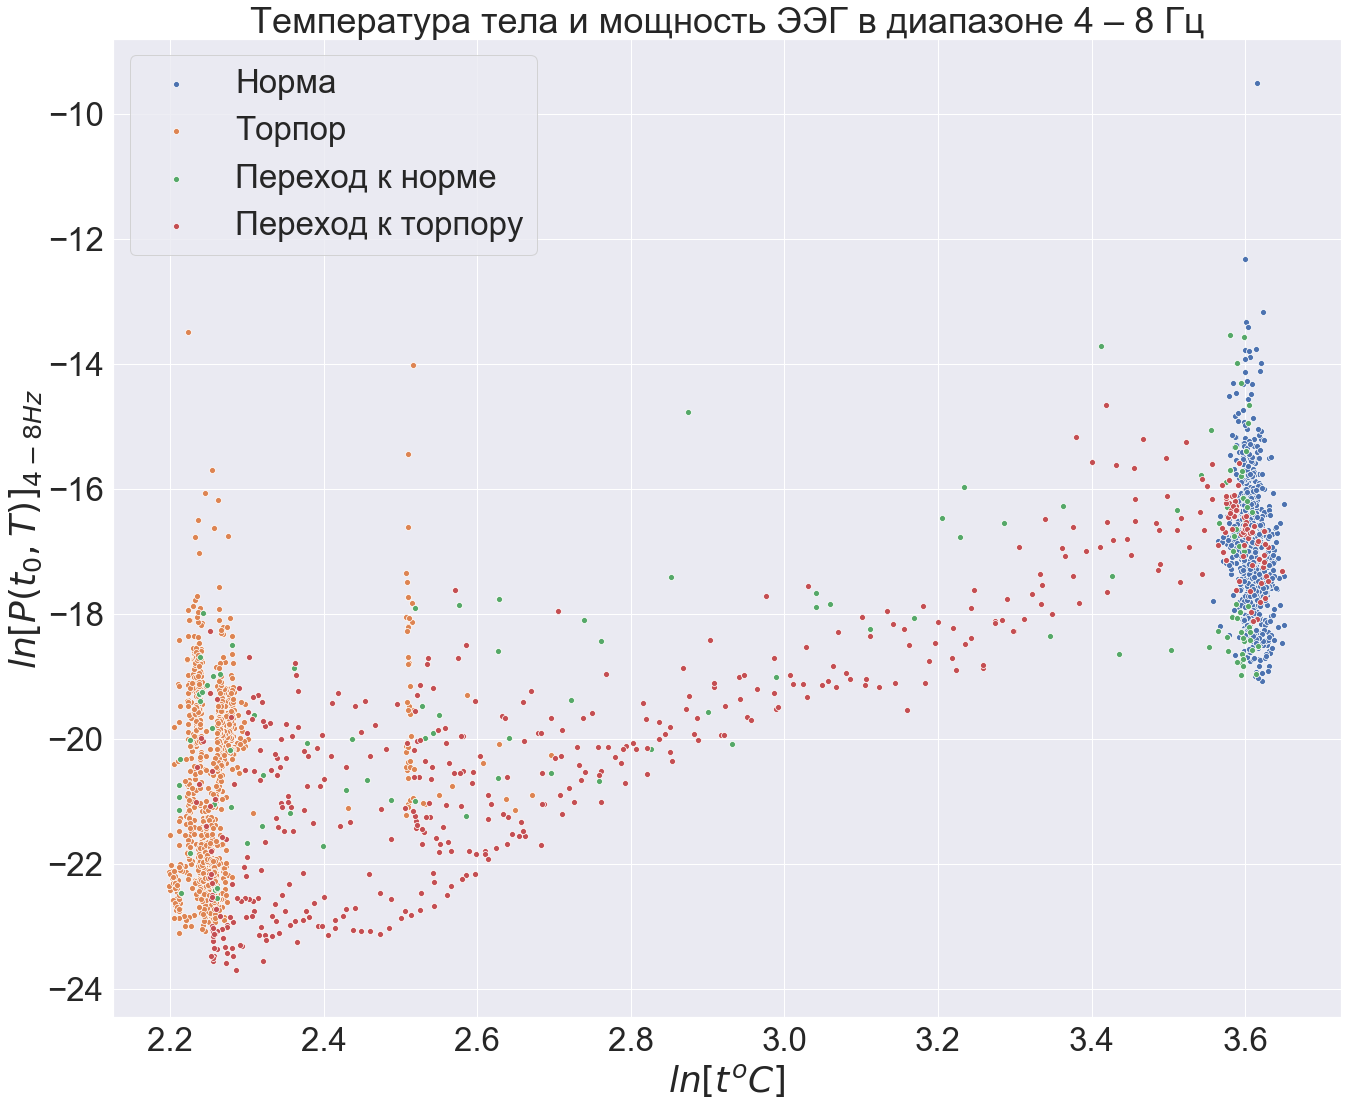

In [31]:
foo = lambda x : np.log(x)

sns.scatterplot(x=foo(main_wake.iloc[:, -5]), y=foo(main_wake.iloc[:, -3]), label="Норма", sizes=100)
sns.scatterplot(x=foo(main_sleep.iloc[:, -5]), y=foo(main_sleep.iloc[:, -3]), label="Торпор")
sns.scatterplot(x=foo(inc.iloc[:, -5]), y=foo(inc.iloc[:, -3]), label="Переход к норме")
sns.scatterplot(x=foo(dec.iloc[:, -5]), y=foo(dec.iloc[:, -3]), label="Переход к торпору")
plt.ylabel(r"$ln[P(t_0, T)]_{4-8 Hz}$")
plt.xlabel(r"$ln[t^o C]$")
plt.title("Температура тела и мощность ЭЭГ в диапазоне 4 – 8 Гц")
plt.show()

/Users/wassilyminkow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/wassilyminkow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.1994681150382808e-38


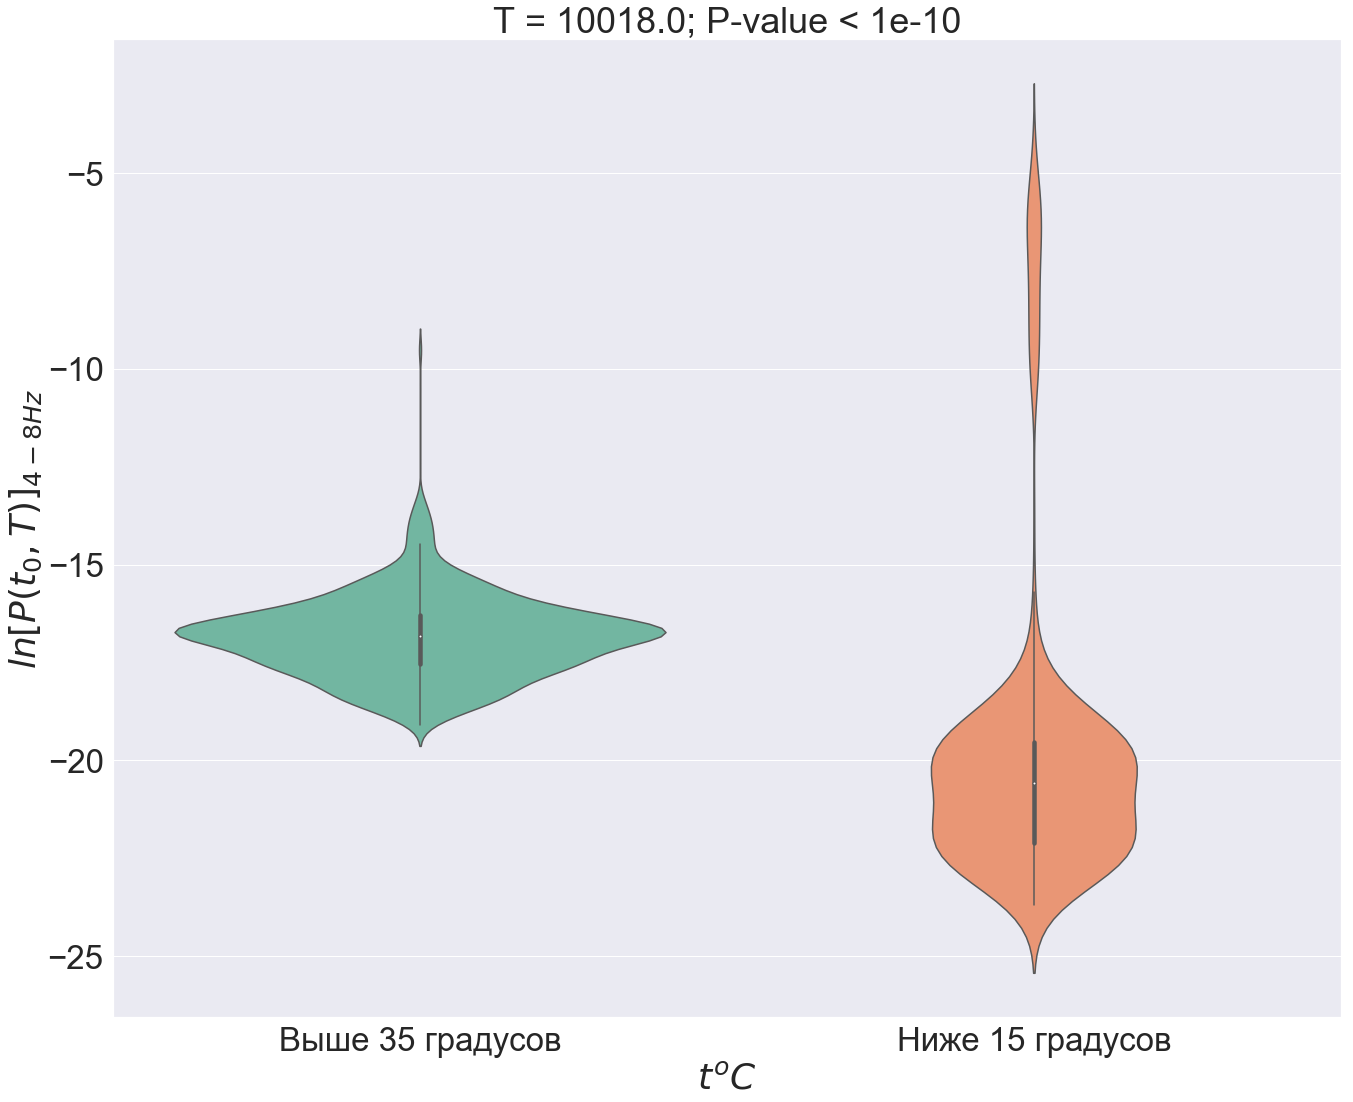

4.479377889557819e-66


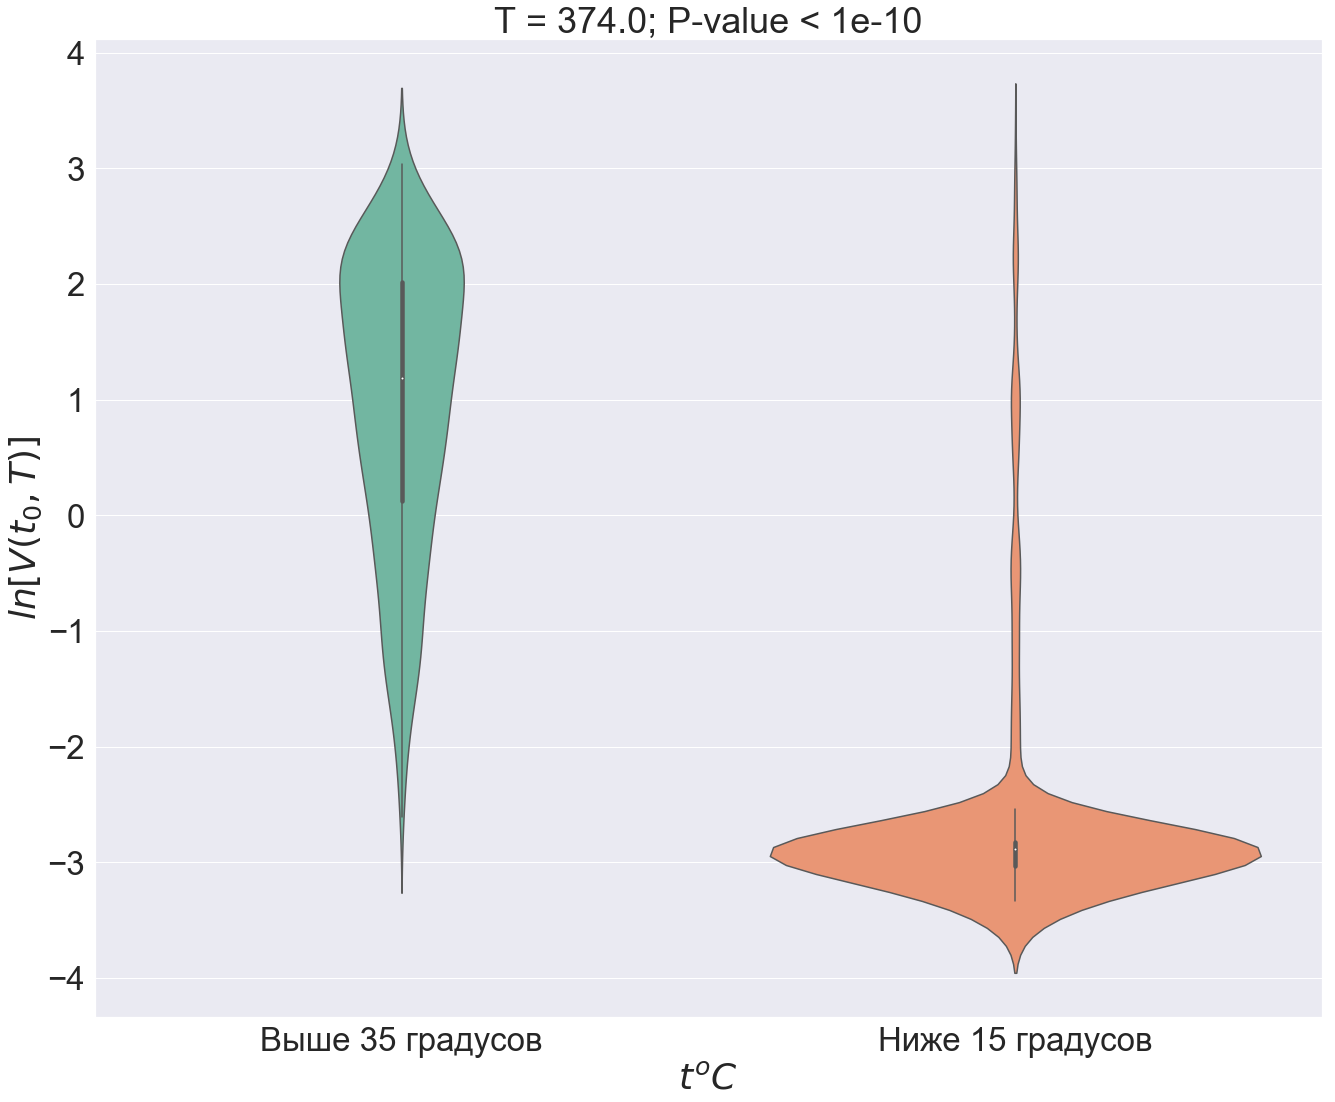

In [32]:
data = temp.copy()
data = pd.concat([data.iloc[:skip_start, :], data.iloc[skip_end:, :]], axis=0).dropna()

data["Температура"] = np.nan
data["Температура"][data["Temperature"] < 15] = "Ниже 15 градусов"
data["Температура"][data["Temperature"] > 35] = "Выше 35 градусов"

feature = ["Power 4 - 8 Hz", "Acceleration"]
rus_feature = [r"$ln[P(t_0, T)]_{4-8 Hz}$", r"$ln[V(t_0, T)]$"]

for i in range(2):
#     plt.subplot(1,2,i+1)
    data[feature[i]] = np.log(data[feature[i]])
    ans = wilcoxon(data[data["Температура"] == "Ниже 15 градусов"][feature[i]].sample(400), 
                   data[data["Температура"] == "Выше 35 градусов"][feature[i]].sample(400))
    
    dummy = round(ans[0], 2)
    print(ans[1])
    if ans[1] < 1e-10: 
        ans = [dummy, "< 1e-10"]
    else:
        ans = [dummy, "= {}".format(round(ans[1], 2))]
    
    sns.violinplot(x="Температура", y=feature[i], data=data, palette="Set2")
#     sns.swarmplot(x="Температура", y=feature[i], data=data, edgecolor="black", alpha=0.5)
    plt.title("Т = {}; P-value {}".format(ans[0], ans[1]))
    plt.xlabel(r"$t^o C$")
    plt.ylabel(rus_feature[i])
    plt.show()

In [33]:
gap = 6*24  # set size of the rolling window 

x = np.log(temp.dropna().iloc[:, -5])  # temperature vector
y = np.log(temp.dropna().iloc[:, -3])  # power vector

p = np.zeros(x.shape[0]-gap) # p-value vector
c = np.zeros(x.shape[0]-gap) # statistic vector

# calculate the rolling corelation coefficient
for i in np.arange(x.shape[0]-gap):
    ans = pearsonr(x[i:i+gap], y[i:i+gap])
    c[i] = ans[0] 
    p[i] = ans[1]

# ajusting p-value with bonferroni method
p_adjusted = multipletests(p, method='bonferroni')[1]

c1 = np.zeros(x.shape[0]-gap)
c2 = np.zeros(x.shape[0]-gap)
c3 = np.zeros(x.shape[0]-gap)

c_green = np.zeros(x.shape[0]-gap)
c_yellow = np.zeros(x.shape[0]-gap)
c_red = np.zeros(x.shape[0]-gap)

c1[(p_adjusted < 0.05) & (np.abs(c) >= 0.9)] = 1
c2[(p_adjusted < 0.05) & (np.abs(c) >= 0.7) & (np.abs(c) < 0.9)] = 1
c3[(p_adjusted < 0.05) & (np.abs(c) >= 0.6) & (np.abs(c) < 0.7)] = 1
c1[c1 < 1] = 0
c2[c2 < 1] = 0
c3[c3 < 1] = 0

num = [c1, c2, c3]
col = [c_green, c_yellow, c_red]

z = list(zip(num, col))

counter = 0

for unit in z:
    for i in range(len(unit[0])):
        if unit[0][i] == 0:
            if counter == 0:
                unit[1][i] = NAN
            else:
                unit[1][i] = time_array[i]
                counter -= 1
        else:
            unit[1][i] = time_array[i]
            counter = gap

z[2][1][z[1][1] == 1] = nan
z[1][1][z[0][1] == 1] = nan
z[2][1][z[0][1] == 1] = nan

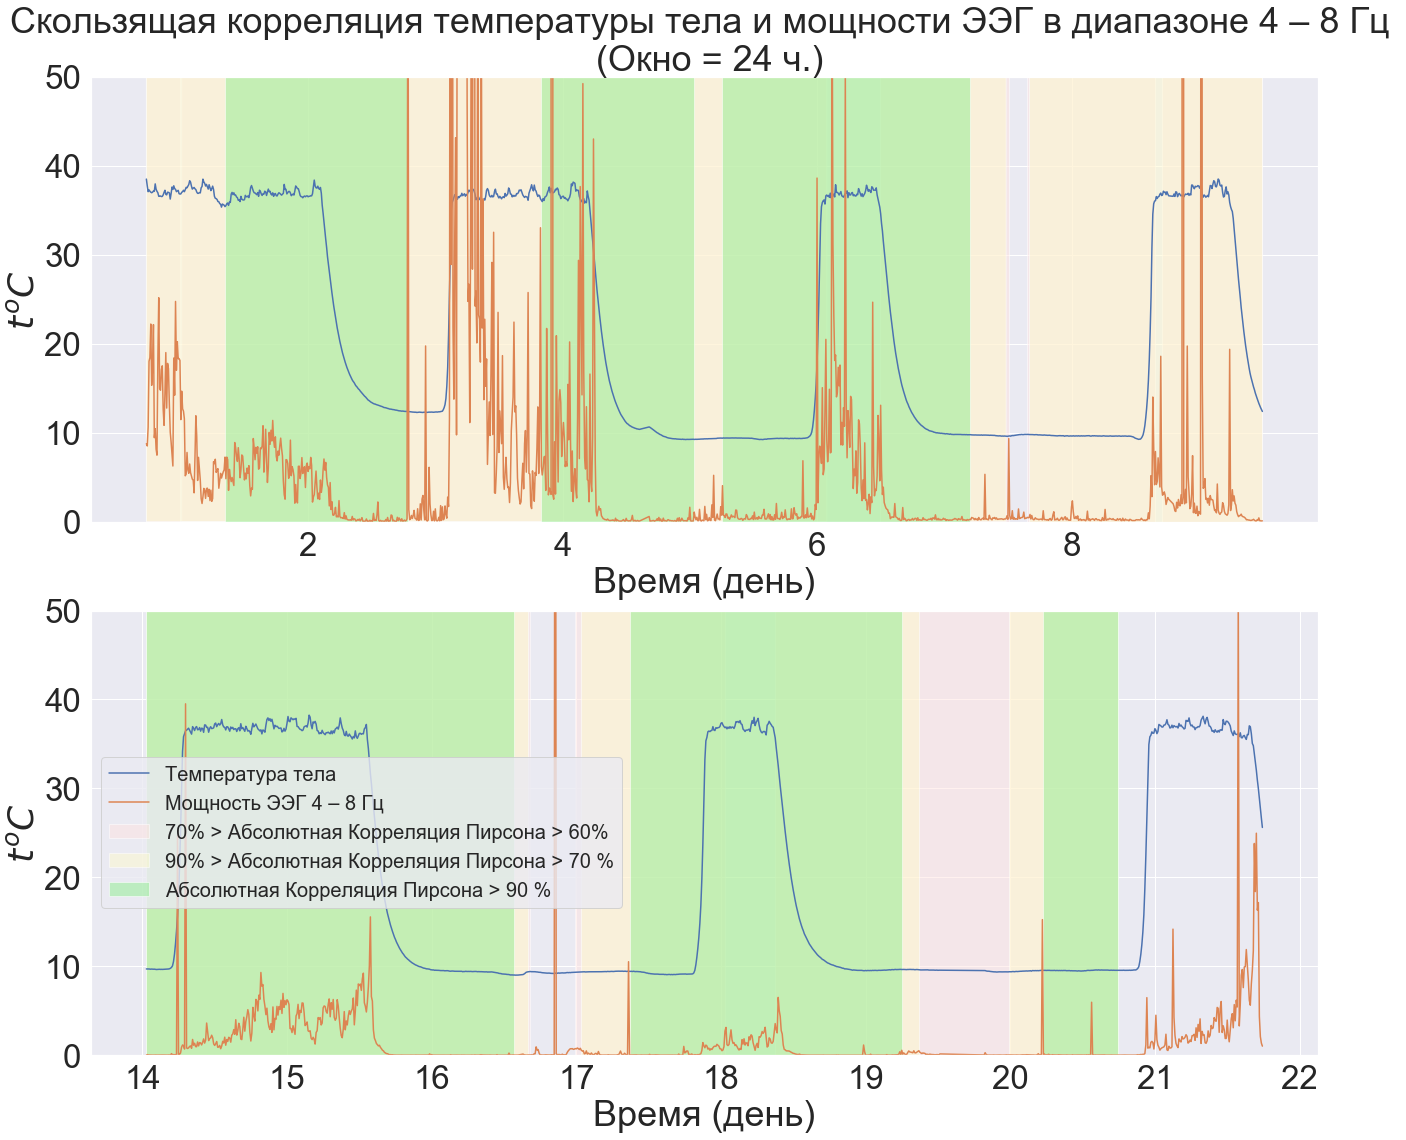

In [34]:
hight = 50

plt.subplot(2, 1, 1)
plt.title("Скользящая корреляция температуры тела и мощности ЭЭГ в диапазоне 4 – 8 Гц \n (Окно = 24 ч.)")
plt.fill_between(z[2][1][:skip_start], np.ones(z[0][1][:skip_start].shape[0])*hight, alpha=0.5, facecolor="mistyrose", label = "70% > Абсолютная Корреляция Пирсона > 60%")
plt.fill_between(z[1][1][:skip_start], np.ones(z[0][1][:skip_start].shape[0])*hight, alpha=0.5, facecolor="lemonchiffon", label = "90% > Абсолютная Корреляция Пирсона > 70 %")
plt.fill_between(z[0][1][:skip_start], np.ones(z[0][1][:skip_start].shape[0])*hight, alpha=0.5, facecolor="lightgreen", label = "Абсолютная Корреляция Пирсона > 90 %")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -5], label="Температура тела")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -3]*coef*10, label="Мощность ЭЭГ сигнала")
plt.ylim([0,hight])
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")

plt.subplot(2, 1, 2)
plt.fill_between(z[2][1][skip_end:], np.ones(z[0][1][skip_end:].shape[0])*hight, alpha=0.5, facecolor="mistyrose", label = "70% > Абсолютная Корреляция Пирсона > 60%")
plt.fill_between(z[1][1][skip_end:], np.ones(z[0][1][skip_end:].shape[0])*hight, alpha=0.5, facecolor="lemonchiffon", label = "90% > Абсолютная Корреляция Пирсона > 70 %")
plt.fill_between(z[0][1][skip_end:], np.ones(z[0][1][skip_end:].shape[0])*hight, alpha=0.5, facecolor="lightgreen", label = "Абсолютная Корреляция Пирсона > 90 %")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -5], label="Температура тела")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -3]*coef*10, label="Мощность ЭЭГ 4 – 8 Гц")
plt.ylim([0, hight])
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend(prop={'size': 20})
plt.show()